# EE519 — Lecture 9 (Linear Prediction / LPC) — Notebook 9.6
## LPC analysis–synthesis (frame-by-frame): residual + filter → reconstruct speech

**Theme:** Source–filter view: estimate the filter **A(z)** and excitation (residual), then synthesize back.

> “What I cannot create, I do not understand.” — Richard Feynman


### 🎯 Learning goals
- Perform **LPC analysis** per frame: get LPC coefficients `a` and LP residual `e`
- Perform **LPC synthesis** per frame: filter excitation through **1/A(z)**
- Reconstruct a full-length waveform via overlap-add
- Listen: original vs reconstructed; measure reconstruction error
- (Optional) compute and visualize **LP cepstral coefficients (LPCC)** as a compact envelope descriptor


## 0. Environment & imports (run this first)

This notebook uses:
- `numpy`, `matplotlib`
- `scipy` (signal + linalg)
- optional: `sounddevice` (recording)
- optional: `sklearn` (mini ML demo only)

If any import fails, the cell prints what to do next.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Core scipy imports (required)
try:
    import scipy.signal as sig
    import scipy.linalg as la
    import scipy.io.wavfile as wavfile
    SCIPY_OK = True
    print("scipy imports: ✅")
except Exception as e:
    SCIPY_OK = False
    print("scipy imports: ❌")
    print("Error:", e)

# Optional recording
try:
    import sounddevice as sd
    HAS_SD = True
    print("sounddevice: ✅ (recording enabled)")
except Exception as e:
    HAS_SD = False
    print("sounddevice: ❌ (recording disabled)")

from pathlib import Path
import json, os, time
from IPython.display import Audio, display


scipy imports: ✅
sounddevice: ✅ (recording enabled)


## 1. Project + manifest workflow (same spirit as Lectures 7/8)

We will use one project folder:
```
EE519_L9_Project/
  recordings/
  figures/
  features/
  cache/
  manifest.json
```

✅ You can re-run this cell any time safely.


In [2]:
PROJECT_DIR = Path("EE519_L9_Project")
REC_DIR = PROJECT_DIR / "recordings"
FIG_DIR = PROJECT_DIR / "figures"
FEAT_DIR = PROJECT_DIR / "features"
CACHE_DIR = PROJECT_DIR / "cache"

for d in [PROJECT_DIR, REC_DIR, FIG_DIR, FEAT_DIR, CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = PROJECT_DIR / "manifest.json"

def load_manifest():
    if MANIFEST_PATH.exists():
        return json.loads(MANIFEST_PATH.read_text())
    return {"clips": [], "meta": {"created": time.time(), "course":"EE519", "lecture":9}}

def save_manifest(m):
    MANIFEST_PATH.write_text(json.dumps(m, indent=2))

manifest = load_manifest()
print("Manifest clips:", len(manifest["clips"]))
print("Project dir:", PROJECT_DIR.resolve())


Manifest clips: 9
Project dir: C:\Users\K\Documents\usc\ee519\ee519-lecture\lecture10\EE519_L9_Project


## 2. Utilities (audio I/O, framing, STFT, saving figures)

These helpers are used throughout Lecture 9 notebooks.


In [3]:
def read_wav(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float32)
    if x.ndim > 1:
        x = x.mean(axis=1)
    if np.max(np.abs(x)) > 1.5:
        x = x / 32768.0
    return fs, x

def peak_normalize(x, target=0.95):
    m = np.max(np.abs(x)) + 1e-12
    return x * (target / m)

def play_audio(x, fs, label=""):
    print(label, f"(fs={fs}, length={len(x)/fs:.2f}s)")
    display(Audio(x, rate=fs))

def savefig(name):
    out = FIG_DIR / name
    plt.savefig(out, dpi=180, bbox_inches="tight")
    print("Saved:", out)

def hann(N):
    return np.hanning(N).astype(np.float32)

def frame_signal(x, N, H):
    if len(x) < N:
        raise ValueError("Signal shorter than frame length N.")
    num = 1 + (len(x) - N) // H
    frames = np.stack([x[i*H:i*H+N] for i in range(num)], axis=0)
    return frames

def stft_scipy(x, fs, win_ms=25, hop_ms=10, nfft=None, window="hann"):
    N = int(win_ms * 1e-3 * fs)
    H = int(hop_ms * 1e-3 * fs)
    if nfft is None:
        nfft = 1 << int(np.ceil(np.log2(N)))
    f, t, Z = sig.stft(x, fs=fs, window=window, nperseg=N, noverlap=N-H, nfft=nfft, boundary=None, padded=False)
    return f, t, Z, N, H

def plot_spectrogram(sig_or_Z, fs, title, fmax=8000, win_ms=25, hop_ms=10, nfft=1024):
    """Plot STFT magnitude spectrogram.
    Accepts either:
      - waveform (1D) -> computes STFT
      - STFT matrix Z (2D: F x T)
    """
    Z = sig_or_Z
    if np.asarray(Z).ndim == 1:
        # waveform -> compute STFT (use our scipy STFT helper for consistency)
        f, t, Z, _, _ = stft_scipy(Z, fs, win_ms=win_ms, hop_ms=hop_ms, nfft=nfft)
        times = t
        freqs = f
    else:
        # assume STFT already
        freqs = np.linspace(0, fs/2, Z.shape[0])
        times = np.arange(Z.shape[1]) * (hop_ms * 1e-3)

    S = 20*np.log10(np.abs(Z) + 1e-12)

    plt.figure(figsize=(10,4))
    plt.imshow(S, origin="lower", aspect="auto",
               extent=[times[0], times[-1] if len(times)>1 else times[0] + 1e-6,
                       freqs[0], freqs[-1]])
    plt.ylim([0, min(fmax, fs/2)])
    plt.colorbar(label="dB")
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")


## LPC core functions (used in Notebooks 9.1–9.4)

### Important fix vs earlier versions
- `toeplitz` is in `scipy.linalg`, not `scipy.signal`.
- We therefore use `la.toeplitz` to avoid errors.

### Autocorrelation convention
We use a **biased** autocorrelation estimate:
\$
r[k] = \sum_{n=0}^{N-1-k} x[n]\,x[n+k]
\$

This is common in LPC autocorrelation method demonstrations.


In [4]:
def autocorr_biased(x, p):
    x = np.asarray(x, dtype=np.float64)
    r = np.zeros(p+1, dtype=np.float64)
    for k in range(p+1):
        r[k] = np.sum(x[:len(x)-k] * x[k:])
    return r

def lpc_autocorr_method(x, p):
    r = autocorr_biased(x, p)
    R = la.toeplitz(r[:-1])  # r[0..p-1]
    rhs = -r[1:]
    a = np.linalg.solve(R + 1e-12*np.eye(p), rhs)
    return a, r

def lpc_residual(x, a):
    A = np.concatenate([[1.0], a])
    e = sig.lfilter(A, [1.0], x)
    return e

def lpc_envelope_db(a, fs, nfft=4096):
    A = np.concatenate([[1.0], a])
    # Use freqz (stable, consistent)
    w, h = sig.freqz([1.0], A, worN=nfft, fs=fs)
    env_db = 20*np.log10(np.abs(h)+1e-12)
    return w, env_db

def fft_mag_db(x, fs, nfft=4096):
    X = np.fft.rfft(x, n=nfft)
    f = np.fft.rfftfreq(nfft, 1/fs)
    mag_db = 20*np.log10(np.abs(X)+1e-12)
    return f, mag_db

def normalize_to_peak(y_db):
    return y_db - np.max(y_db)


## 2. Load a clip (choose by label or filename)

In [5]:

def pick_clip(manifest, *, label=None, filename=None, require_selections=True):
    """
    Pick a clip from manifest["clips"].
    - If filename is provided, matches exact filename.
    - Else if label is provided, matches label.
    - Else returns first clip (optionally requiring frame_selections).
    """
    clips = manifest.get("clips", [])
    if filename is not None:
        for i,c in enumerate(clips):
            if c.get("filename") == filename:
                if (not require_selections) or ("frame_selections" in c):
                    return i,c
                raise RuntimeError(f"Clip '{filename}' found but has no frame_selections. Run Notebook 9.0 first.")
        raise RuntimeError(f"No clip with filename='{filename}' in manifest.")
    if label is not None:
        for i,c in enumerate(clips):
            if c.get("label") == label and ((not require_selections) or ("frame_selections" in c)):
                return i,c
    # fallback: first clip with selections (or first clip)
    if require_selections:
        for i,c in enumerate(clips):
            if "frame_selections" in c:
                return i,c
        raise RuntimeError("No clip has frame_selections. Run Notebook 9.0 to select and save frames.")
    if len(clips)==0:
        raise RuntimeError("manifest has no clips. Run Notebook 9.0 to record/load a file and save manifest.")
    return 0, clips[0]

manifest = load_manifest()

# ----------------------------
# 🔧 Choose ONE of these:
# ----------------------------
PICK_BY = "label"      # "label" or "filename" or "auto"
TARGET_LABEL = "vowel" # e.g., "vowel", "fricative", "speech"
TARGET_FILENAME = None # e.g., "my_recording.wav"

if PICK_BY == "filename" and TARGET_FILENAME:
    CLIP_IDX, clip = pick_clip(manifest, filename=TARGET_FILENAME, require_selections=True)
elif PICK_BY == "label":
    CLIP_IDX, clip = pick_clip(manifest, label=TARGET_LABEL, require_selections=True)
else:
    CLIP_IDX, clip = pick_clip(manifest, require_selections=True)

print("Using clip:", CLIP_IDX, clip["filename"], "| label:", clip.get("label"))

fs, x = read_wav(REC_DIR / clip["filename"])
x = peak_normalize(x)

sel = clip["frame_selections"]
WIN_MS = sel.get("win_ms", 25)
HOP_MS = sel.get("hop_ms", 10)
N = int(WIN_MS*1e-3*fs)
H = int(HOP_MS*1e-3*fs)

raw_frames = frame_signal(x, N, H)
win = hann(N)
frames = raw_frames * win[None,:]   # windowed frames (for LPC analysis)
vowel_frames = sel.get("vowel_frames", [])
fric_frames = sel.get("fricative_frames", [])
sil_frames = sel.get("silence_frames", [])

print("Frame params | WIN_MS:", WIN_MS, "HOP_MS:", HOP_MS, "N:", N, "H:", H)
print("Counts | vowel:", len(vowel_frames), "fric:", len(fric_frames), "sil:", len(sil_frames))


Using clip: 6 F01_fric_s.wav | label: fricative
Frame params | WIN_MS: 25 HOP_MS: 10 N: 400 H: 160
Counts | vowel: 30 fric: 10 sil: 4


## 3. Frame-by-frame LPC analysis → residual + coefficients

In [6]:

P = 14
EPS = 1e-10

w = hann(N)
wsq = (w**2).astype(np.float64)

num_frames = frames.shape[0]
a_all = np.zeros((num_frames, P), dtype=np.float64)
e_all = np.zeros_like(raw_frames)

for i in range(num_frames):
    a, _ = lpc_autocorr_method(frames[i], P)
    a_all[i] = a
    e_all[i] = lpc_residual(raw_frames[i], a)

print("Computed LPC a_all:", a_all.shape, "| residual frames:", e_all.shape)


Computed LPC a_all: (398, 14) | residual frames: (398, 400)


In [7]:

# Time axis (frame centers) — useful for later visualizations
t_frames = (np.arange(num_frames) * H + (N/2)) / fs

def frames_to_sample_range(frame_ids, N, H):
    """Convert a list of frame indices to an (start_sample, end_sample) range."""
    if len(frame_ids)==0:
        return None
    f0 = int(min(frame_ids))
    f1 = int(max(frame_ids))
    start = f0 * H
    end = f1 * H + N
    return start, end


## 4. LPC synthesis per frame → overlap-add full signal
Given residual `e[n]` and LPC coefficients `a`, we synthesize:
\[
\hat{x}[n] = \frac{1}{A(z)} e[n] 
\]
implemented as `lfilter([1], a, e)`.

In [8]:

xhat_frames = np.zeros_like(raw_frames)

for i in range(num_frames):
    a = np.r_[1.0, a_all[i]]
    e = e_all[i]
    xhat_frames[i] = sig.lfilter([1.0], a, e)

# Overlap-add to full length (window-squared normalization)
xhat = np.zeros(len(x), dtype=np.float64)
wacc = np.zeros(len(x), dtype=np.float64)

for i in range(num_frames):
    start = i * H
    end = start + N
    if end > len(x):
        break
    xhat[start:end] += xhat_frames[i] * w
    wacc[start:end] += wsq

mask = wacc > EPS
xhat_ola = np.zeros_like(xhat)
xhat_ola[mask] = xhat[mask] / wacc[mask]

# Simple error metrics
min_len = min(len(x), len(xhat_ola))
err = x[:min_len] - xhat_ola[:min_len]
snr = 10*np.log10(np.sum(x[:min_len]**2) / (np.sum(err**2) + 1e-12))
print("Reconstruction SNR (dB):", float(snr))


Reconstruction SNR (dB): -15.197761427014779


### 🔊 Listen: original vs reconstructed

In [9]:

print("Original:")
play_audio(x, fs)

print("Reconstructed (LPC analysis–synthesis):")
play_audio(normalize_to_peak(xhat_ola[100:-100]), fs)


Original:
 (fs=16000, length=4.00s)


Reconstructed (LPC analysis–synthesis):
 (fs=16000, length=3.99s)


## 5. Compare waveforms + spectrograms

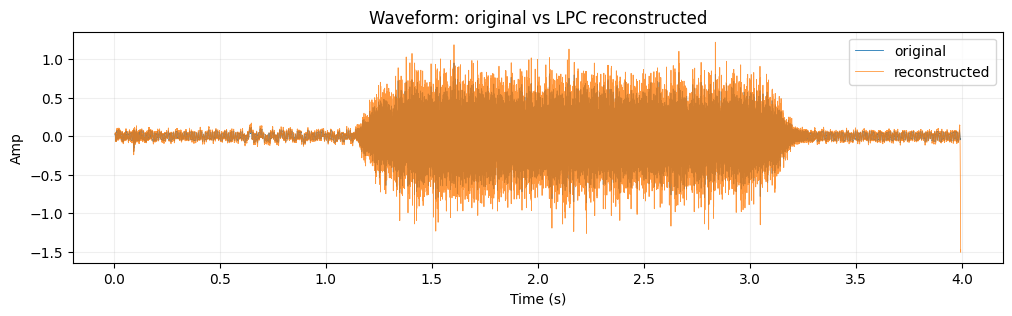

<Figure size 1200x400 with 0 Axes>

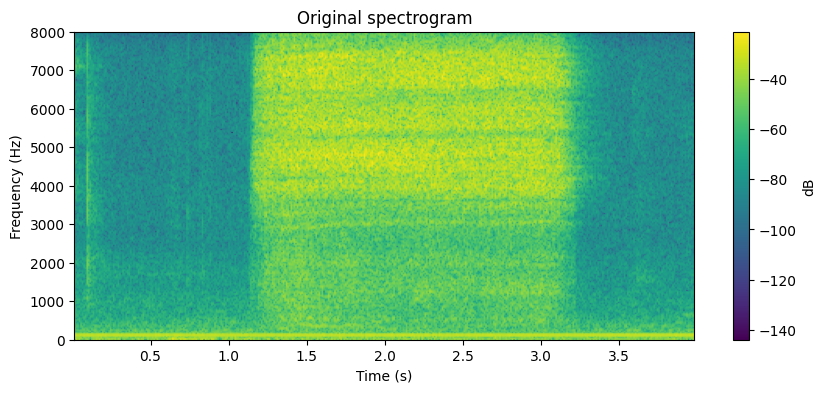

<Figure size 1200x400 with 0 Axes>

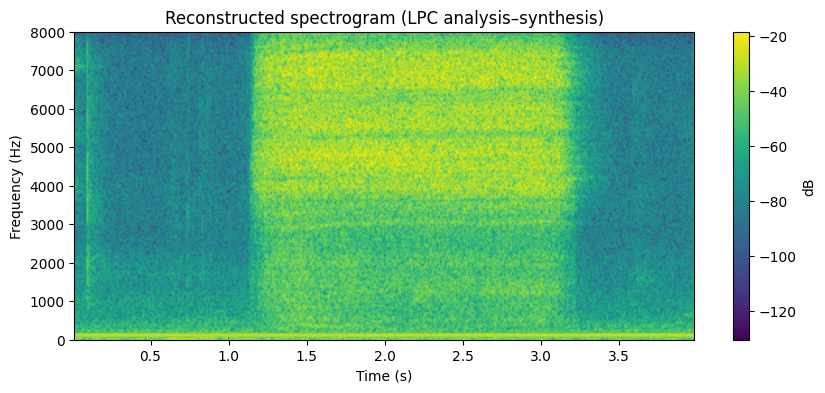

In [10]:

t = np.arange(len(x))/fs

plt.figure(figsize=(12,3))
#plt.plot(t, x, linewidth=0.6, label="original")
plt.plot(t[100: -100], x[100: -100], linewidth=0.6, label="original")
plt.plot(t[100: -100], xhat_ola[100: -100], linewidth=0.6, label="reconstructed", alpha=0.8)
plt.title("Waveform: original vs LPC reconstructed")
plt.xlabel("Time (s)"); plt.ylabel("Amp")
plt.grid(True, alpha=0.2); plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plot_spectrogram(x, fs, title="Original spectrogram")
plt.show()

plt.figure(figsize=(12,4))
plot_spectrogram(xhat_ola, fs, title="Reconstructed spectrogram (LPC analysis–synthesis)")
plt.show()


## 6. Vowel-only synthesis experiments (residual vs synthetic excitation)
For a vowel region, try different excitations:
- **True residual** (best reconstruction)
- **Impulse train** (voiced-like)
- **White noise** (unvoiced-like)

This helps connect LPC to the classic source–filter intuition.

In [11]:

def impulse_train(length, fs, f0_hz=120.0):
    y = np.zeros(length, dtype=np.float64)
    if f0_hz <= 0:
        return y
    period = int(round(fs / f0_hz))
    period = max(period, 1)
    y[::period] = 1.0
    return y

rng = frames_to_sample_range(vowel_frames, N, H)
if rng is None:
    print("No vowel_frames saved in manifest. Run Notebook 9.0 selections.")
else:
    s0, s1 = rng
    s0 = max(0, s0); s1 = min(len(x), s1)
    # build a quick synthesis using the MIDDLE vowel frame's LPC as a constant filter
    mid_f = vowel_frames[len(vowel_frames)//2]
    a_v = a_all[mid_f]

    true_e = y_ola[s0:s1] if "y_ola" in globals() else None  # if you ran 9.5 first in same kernel
    e_imp = impulse_train(s1-s0, fs, f0_hz=120.0)
    e_noise = np.random.randn(s1-s0)

    # synthesize
    y_imp = sig.lfilter([1.0], a_v, e_imp)
    y_noise = sig.lfilter([1.0], a_v, e_noise)

    print("Original vowel region:")
    play_audio(x[s0:s1], fs)

    print("Synth using impulse-train excitation (fixed LPC from one frame):")
    play_audio(normalize_to_peak(y_imp), fs)

    print("Synth using white-noise excitation (fixed LPC from one frame):")
    play_audio(normalize_to_peak(y_noise), fs)

    if true_e is not None:
        y_true = sig.lfilter([1.0], a_v, true_e)
        print("Synth using *true residual* excitation (if available):")
        play_audio(normalize_to_peak(y_true), fs)


Original vowel region:
 (fs=16000, length=0.32s)


Synth using impulse-train excitation (fixed LPC from one frame):
 (fs=16000, length=0.32s)


Synth using white-noise excitation (fixed LPC from one frame):
 (fs=16000, length=0.32s)


## 7. (Optional) LPCC features over time
LP cepstral coefficients (LPCCs) are a compact way to represent the all-pole envelope.
Here we compute LPCCs from the LPC coefficients per frame and visualize them like a feature map.

In [12]:
def lpc_to_lpcc(a, num_ceps=13, c0=0.0, lpc_sign="minus"):
    """
    a: LPC coefficients length p+1 with a[0]=1.
    num_ceps: number of cepstra (including c[0]).
    c0: value for c[0] (often log(gain)); set 0 if you only care about shape.
    lpc_sign: "minus" uses c[n] = -a[n] - s, "plus" uses c[n] =  a[n] + s
    """
    a = np.asarray(a, dtype=np.float64)
    p = len(a) - 1
    c = np.zeros(num_ceps, dtype=np.float64)
    c[0] = c0

    for n in range(1, num_ceps):
        s = 0.0
        kmin = max(1, n - p)          # ensures (n-k) <= p
        kmax = min(n - 1, num_ceps-1) # ensures k is a valid cepstral index
        for k in range(kmin, kmax + 1):
            s += (k / n) * c[k] * a[n - k]

        if n <= p:
            if lpc_sign == "minus":
                c[n] = -a[n] - s
            else:
                c[n] =  a[n] + s
        else:
            c[n] = -s if lpc_sign == "minus" else s

    return c

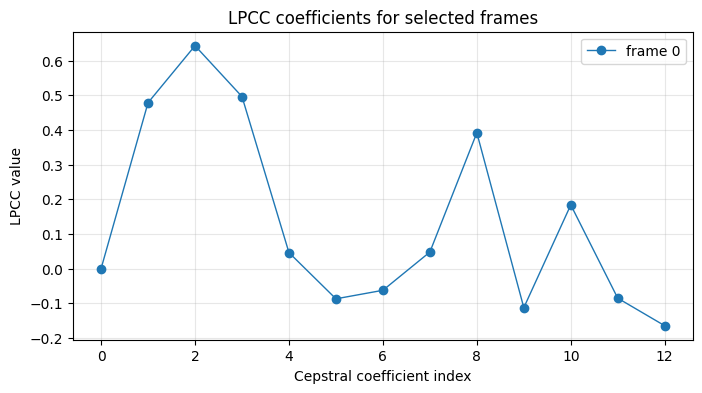

In [17]:
frames_to_plot = [0]  # pick any frame indices you want

plt.figure(figsize=(8,4))
for i in frames_to_plot:
    plt.plot(np.arange(NUM_CEPS), C[i], marker="o", linewidth=1, label=f"frame {i}")

plt.xlabel("Cepstral coefficient index")
plt.ylabel("LPCC value")
plt.title("LPCC coefficients for selected frames")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

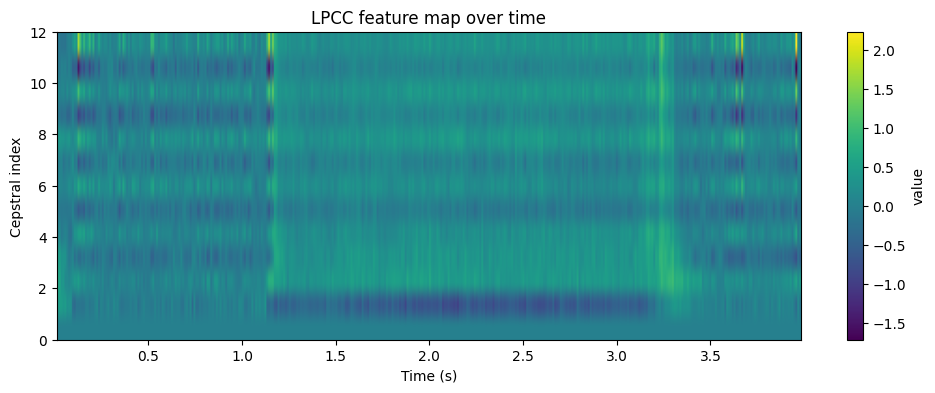

In [16]:

def lpc_to_lpcc(a, num_ceps=13):
    """
    Convert LPC coefficients a (len p+1, a[0]=1) to LPCCs c[0..num_ceps-1].
    Returns c with c[0] = log(gain) approximated as 0 here (envelope shape focus).
    """
    a = np.asarray(a, dtype=np.float64)
    p = len(a)-1
    c = np.zeros(num_ceps, dtype=np.float64)
    # c[0] often includes log-gain; we set to 0 for simplicity
    for n in range(1, num_ceps):
        s = 0.0
        kmax = min(n-1, p)
        for k in range(1, kmax+1):
            s += (k/n) * c[k] * a[n-k]
        if n <= p:
            c[n] = -a[n] - s
        else:
            c[n] = -s
    return c

NUM_CEPS = 13
C = np.zeros((num_frames, NUM_CEPS), dtype=np.float64)
for i in range(num_frames):
    C[i] = lpc_to_lpcc(a_all[i], num_ceps=NUM_CEPS)

plt.figure(figsize=(12,4))
plt.imshow(C.T, origin="lower", aspect="auto",
           extent=[t_frames[0], t_frames[-1], 0, NUM_CEPS-1])
plt.title("LPCC feature map over time")
plt.xlabel("Time (s)")
plt.ylabel("Cepstral index")
plt.colorbar(label="value")
plt.show()


## ✅ Reflection questions
1. Where does reconstruction degrade most: fricatives, transitions, or silence? Why?
2. Try changing `P`. When does the reconstructed speech start to sound ‘buzzy’ or unstable?
3. Why can a fixed LPC filter + impulse train sound vowel-like, but fail for fricatives?
4. If you were to compress speech, what would you store per frame: `a`, residual, pitch, gain, or LPCCs?


### Answers

1. Reconstruction degrades the most in frications and transitions since they violate the all-pole stationary assumptions.
2. It sounds buzzy as p increases. In my opinion it already sounded buzzy at 14.
3. Vowels work better under the source filter model while fricatives are more like noise. As such, they are easier to represent with LPC filter + impulse train.
4. I would store LPCCs, pitch, and, gain over residuals for compression.